# Plot regridded and time-averaged LFRic data

In [14]:
import warnings
from dataclasses import dataclass, field
from typing import Iterable, Sequence, Optional, List

warnings.filterwarnings("ignore")

import cmcrameri
import cmocean
import iris
import matplotlib.colors as mcol
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import paths
import swiftascmaps
from aeolus.calc import (
    calc_derived_cubes,
    d_dz,
    meridional_mean,
    spatial_mean,
    toa_net_energy,
    vertical_mean,
    zonal_mean,
)
from aeolus.const import init_const
from aeolus.coord import ensure_bounds
from aeolus.io import load_data
from aeolus.model import lfric
from aeolus.plot import (
    add_custom_legend,
    capitalise,
    cube_minmeanmax_str,
    figsave,
    hcross,
    linspace_pm1,
    map_scatter,
    subplot_label_generator,
    tex2cf_units,
    timeseries_1d,
)
from aeolus.runtime import RUNTIME
from aeolus.subset import DimConstr, unique_cubes
from common import DAYSIDE, NIGHTSIDE, SIMULATIONS
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
lfric.ghgt = "geopotential_height"
lfric.m_v = "m_v"
DC = DimConstr(model=lfric)
RUNTIME.figsave_reduce_size = True
KW_ZERO_LINE = dict(
    color=plt.rcParams["axes.edgecolor"],
    linewidth=plt.rcParams["axes.linewidth"],
    linestyle="dashed",
    dash_capstyle="round",
)

In [3]:
n_res = 512
show_sim = [*SIMULATIONS.keys()]
const = init_const("hab1", directory=paths.const)

In [4]:
dset = {}
for sim_label in show_sim:
    dset_averages = dset[sim_label] = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_averages_*_time_mean_and_regr_{n_res}.nc".lower()
    )
    dset_inst_diag = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_inst_diag_*_time_mean_and_regr_{n_res}.nc".lower()
    )
    dset_averages = iris.cube.CubeList(
        cube
        for cube in dset_averages
        if cube.var_name
        not in [
            "tot_col_w_kinetic_energy",
            "tot_col_uv_kinetic_energy",
            "cell_area",
        ]
    )
    dset[sim_label] = dset_averages + dset_inst_diag
    calc_derived_cubes(dset[sim_label], const=const, model=lfric)

for i, cube in enumerate(dset[sim_label]):
    print(f"---|---|-{'-'*30}-|-{'-'*60}")
    print(f"{i:<2d} | {cube.ndim} | {str(cube.var_name):>30} | {cube.name():>60}")

---|---|--------------------------------|-------------------------------------------------------------
0  | 2 |                   tot_col_m_cl |                atmosphere_mass_content_of_cloud_liquid_water
---|---|--------------------------------|-------------------------------------------------------------
1  | 3 |                            m_v |                                          vapour_mixing_ratio
---|---|--------------------------------|-------------------------------------------------------------
2  | 3 |                   exner_in_wth |                            exner_pressure_at_cell_interfaces
---|---|--------------------------------|-------------------------------------------------------------
3  | 2 |                    tot_col_m_v |                       atmosphere_mass_content_of_water_vapor
---|---|--------------------------------|-------------------------------------------------------------
4  | 2 |                   tot_col_m_ci |                         atmosph

In [5]:
lons = dset[sim_label].extract(DimConstr(model=lfric).relax.x)[0].coord(lfric.x).points
lats = dset[sim_label].extract(DimConstr(model=lfric).relax.y)[0].coord(lfric.y).points
heights = (
    dset[sim_label].extract(DimConstr(model=lfric).relax.z)[0].coord(lfric.z).points
)

In [6]:
coord_mappings = {
    "longitude": dict(ticks=np.arange(-180, 181, 60), units="degrees"),
    "latitude": dict(ticks=np.arange(-90, 91, 30), units="degrees"),
    "level_height": dict(ticks=np.arange(0, 41, 5), units="km"),
}

## Maps

In [7]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    kw_plt: dict = field(default_factory=dict)
    method: str = "contourf"

In [38]:
DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.t_sfc),
        title="Surface Temperature",
        units="$K$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.thermal,
            # levels=np.arange(180, 291, 10),
            vmin=180,
            vmax=290,
            # extend="both",
        ),
    ),
    "toa_olr": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.toa_olr),
        title="TOA Outgoing Longwave Radiation",
        units="$W$ $m^{-2}$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.gray,
            # levels=np.arange(180, 291, 10),
            vmin=90,
            vmax=240,
            # extend="both",
        ),
    ),
    "caf": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.caf),
        title="Cloud Fraction",
        units="%",
        method="contourf",
        kw_plt=dict(cmap=cmcrameri.cm.batlowK, levels=np.arange(0, 101, 10)),
    ),
    "caf_vl": Diag(
        recipe=lambda cl: cl.extract_cube("very_low_type_cloud_amount"),
        title="Very Low Cloud Fraction",
        units="%",
        method="contourf",
        kw_plt=dict(cmap=cmcrameri.cm.batlowK, levels=np.arange(0, 101, 10)),
    ),
    "caf_l": Diag(
        recipe=lambda cl: cl.extract_cube("low_type_cloud_amount"),
        title="Low Cloud Fraction",
        units="%",
        method="contourf",
        kw_plt=dict(cmap=cmcrameri.cm.batlowK, levels=np.arange(0, 101, 10)),
    ),
    "caf_m": Diag(
        recipe=lambda cl: cl.extract_cube("medium_type_cloud_amount"),
        title="Medium Cloud Fraction",
        units="%",
        method="contourf",
        kw_plt=dict(cmap=cmcrameri.cm.batlowK, levels=np.arange(0, 101, 10)),
    ),
    "caf_h": Diag(
        recipe=lambda cl: cl.extract_cube("high_type_cloud_amount"),
        title="High Cloud Fraction",
        units="%",
        method="contourf",
        kw_plt=dict(cmap=cmcrameri.cm.batlowK, levels=np.arange(0, 101, 10)),
    ),
    "caf_vh": Diag(
        recipe=lambda cl: cl.extract_cube("very_high_type_cloud_amount"),
        title="Very High Cloud Fraction",
        units="%",
        method="contourf",
        kw_plt=dict(cmap=cmcrameri.cm.batlowK, levels=np.arange(0, 101, 10)),
    ),
    "u_zm": Diag(
        recipe=lambda cl: zonal_mean(cl.extract_cube(lfric.u)),
        title="Eastward Wind",
        units="$m$ $s^{-1}$",
        method="contourf",
        kw_plt=dict(
            cmap=swiftascmaps.nineteen_eighty_nine_tv_r,
            levels=np.arange(-70, 71, 10),
            extend="both",
        ),
    ),
    "v_zm": Diag(
        recipe=lambda cl: zonal_mean(cl.extract_cube(lfric.v)),
        title="Northward Wind",
        units="$m$ $s^{-1}$",
        method="contourf",
        kw_plt=dict(
            cmap=swiftascmaps.nineteen_eighty_nine_tv_r,
            levels=np.arange(-30, 31, 5),
            extend="both",
        ),
    ),
    "w_zm_day": Diag(
        recipe=lambda cl: zonal_mean(
            cl.extract_cube(lfric.w).extract(DAYSIDE.constraint)
        ),
        title="Upward Wind, Day Side",
        units="$10^{-2}$ $m$ $s^{-1}$",
        method="contourf",
        kw_plt=dict(
            cmap=swiftascmaps.nineteen_eighty_nine_tv_r,
            levels=np.arange(-3, 3.1, 0.5),
            extend="both",
        ),
    ),
    "temp_zm": Diag(
        recipe=lambda cl: zonal_mean(
            cl.extract_cube(lfric.thta) * cl.extract_cube(lfric.exner)
        ),
        title="Temperature",
        units="$K$",
        method="contourf",
        kw_plt=dict(
            cmap=cmocean.cm.thermal,
            levels=np.arange(170, 271, 10),
            extend="both",
        ),
    ),
    "tot_col_m_v": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_v"),
        title="Total Column Water Vapour",
        units="$kg$ $m^{-2}$",
        method="contourf",
        kw_plt=dict(
            cmap=cmocean.cm.dense,
            levels=[0.1, 1, 2, 4, 8, 12, 20, 30, 40],
            extend="both",
        ),
    ),
    "tot_col_m_cl": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_cl"),
        title="Total Column Cloud Liquid",
        units="$kg$ $m^{-2}$",
        method="contourf",
        kw_plt=dict(
            cmap=cmocean.cm.tempo,
            levels=np.arange(0.02, 0.21, 0.02),
            extend="both",
        ),
    ),
    "tot_col_m_ci": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_ci"),
        title="Total Column Cloud Ice",
        units="$kg$ $m^{-2}$",
        method="contourf",
        kw_plt=dict(
            cmap=cmocean.cm.ice_r,
            levels=np.arange(0.1, 1.1, 0.1),
            extend="both",
        ),
    ),
    "tot_col_uv_kinetic_energy": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_uv_kinetic_energy"),
        title="Total Column Horizontal Kinetic Energy",
        units="$10^6$ $J$ $m^{-2}$",
        method="contourf",
        kw_plt=dict(
            cmap=cmocean.cm.amp,
            levels=np.arange(0.0, 2.1, 0.5) * 1e1,
            extend="both",
        ),
    ),
    "tot_col_w_kinetic_energy": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_w_kinetic_energy"),
        title="Total Column Vertical Kinetic Energy",
        units="$J$ $m^{-2}$",
        method="contourf",
        kw_plt=dict(
            cmap=cmocean.cm.amp,
            levels=np.logspace(-2, 3, 6),
            norm=mcol.LogNorm(),
            extend="both",
        ),
    ),
}

Saved to ../figures/drafts/regr__c192s10e_c192s10r_c192s10p_c192p__caf_caf_vl_caf_l_caf_m_caf_h_caf_vh__tm.png
Size: 139.9 KB


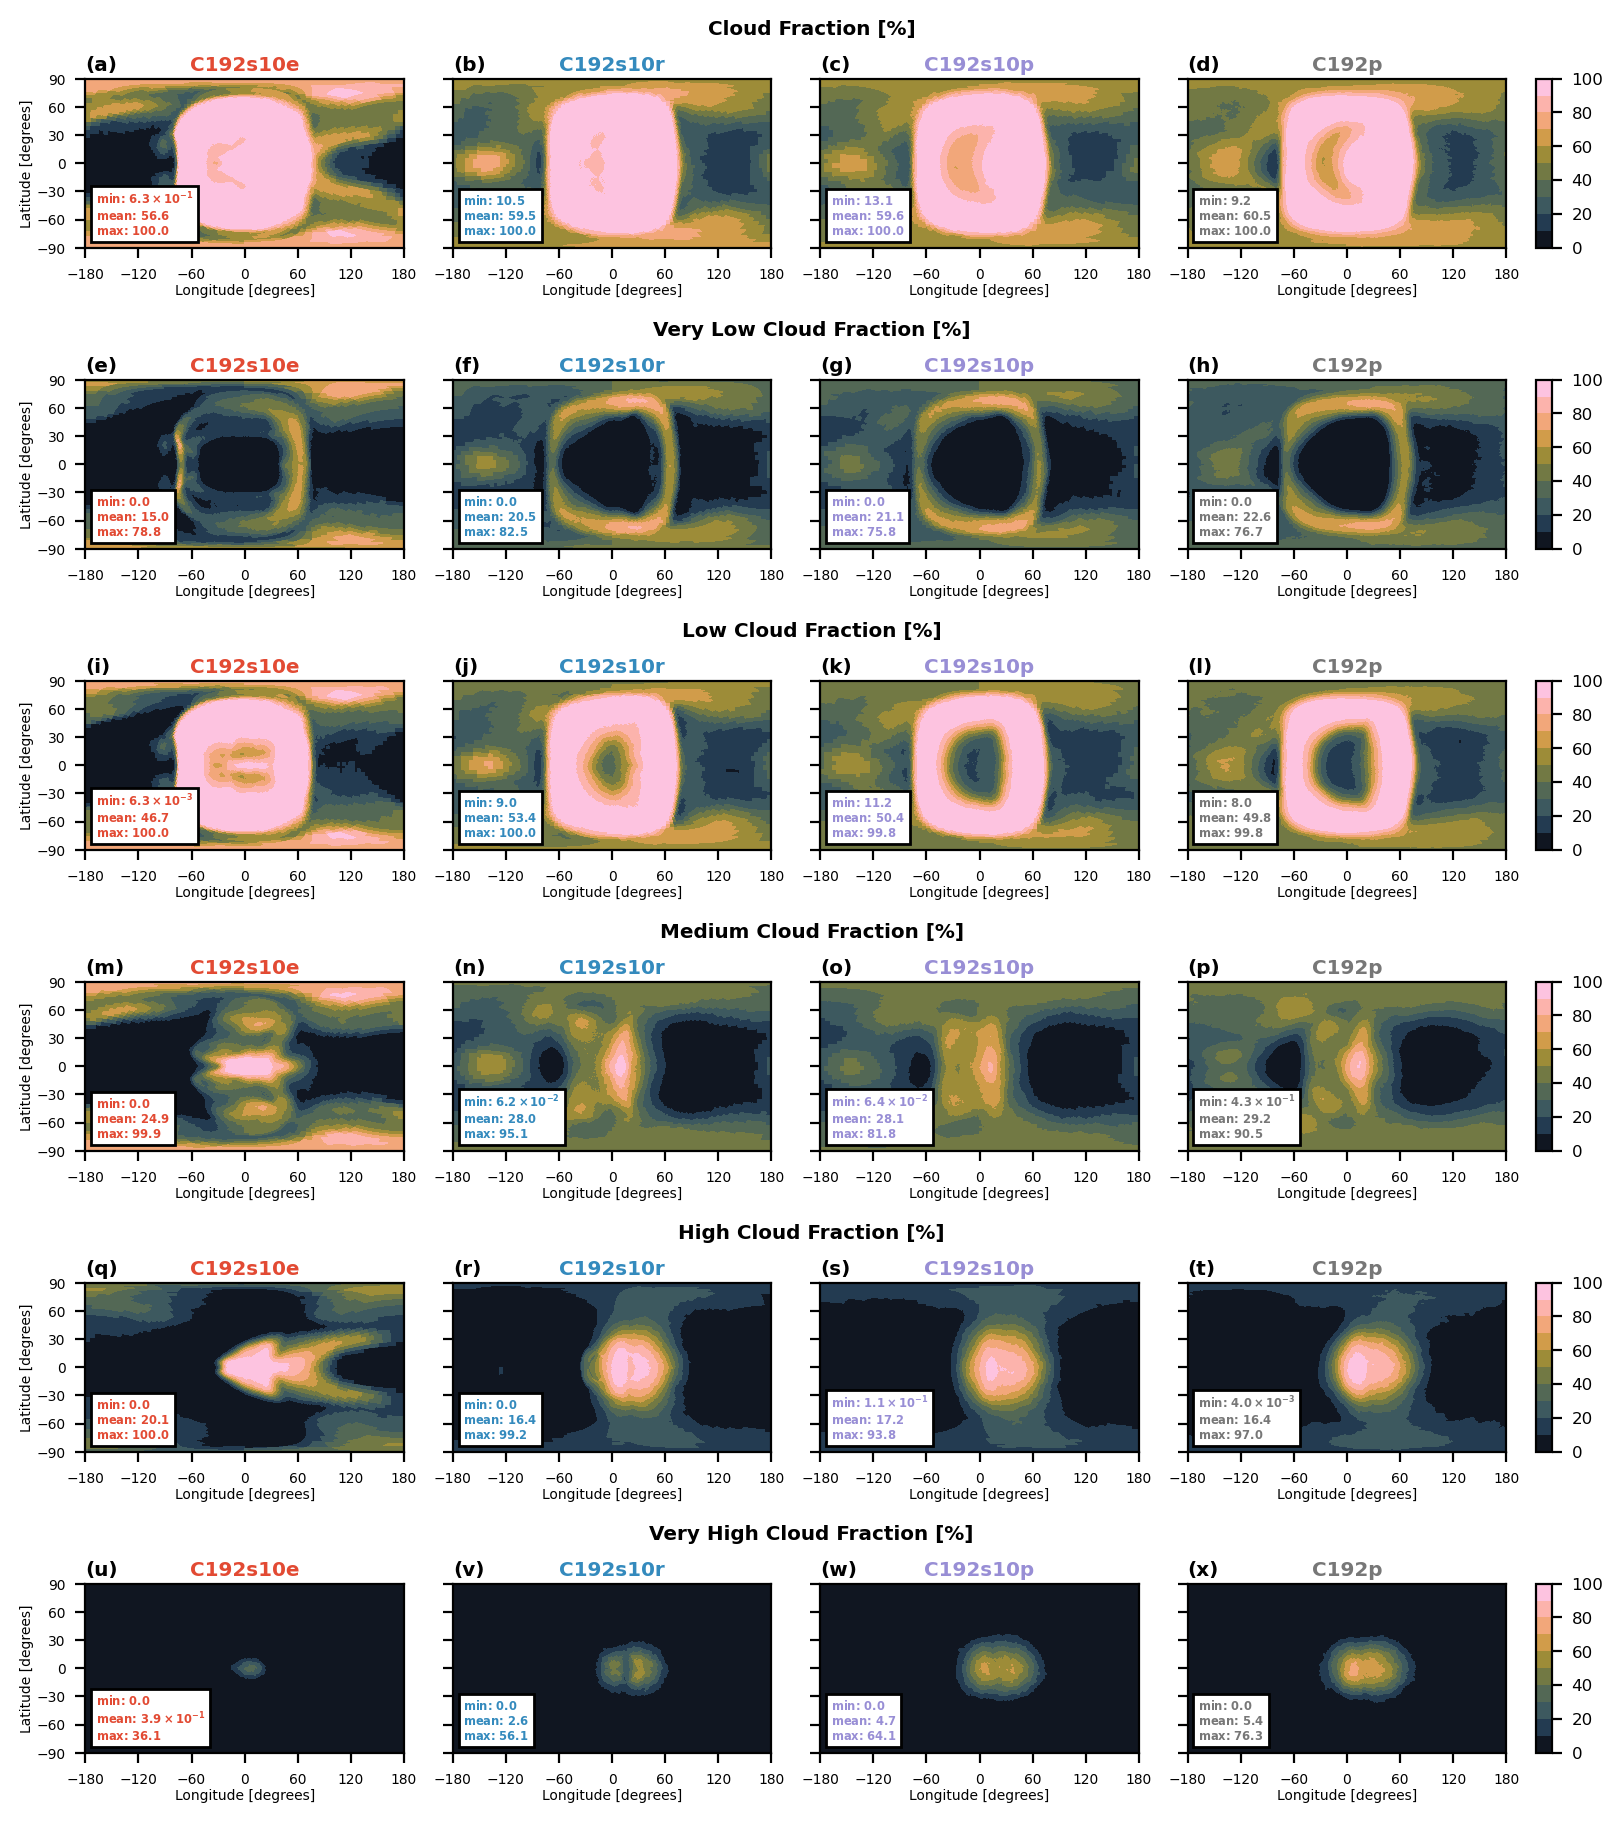

In [42]:
# diag_keys = ["tot_col_uv_kinetic_energy", "tot_col_w_kinetic_energy"]
# diag_keys = ["tot_col_m_v", "tot_col_m_cl", "tot_col_m_ci"]
# diag_keys = ["t_sfc", "toa_olr", "caf"]
diag_keys = ["caf", "caf_vl", "caf_l", "caf_m", "caf_h", "caf_vh"]
savefig = True
fmt = "pretty"
plot_winds = ["t_sfc"]
height_constraint = iris.Constraint(**{lfric.z: 8000})

fig = plt.figure(figsize=(8, 1.5 * len(diag_keys)), layout="constrained")
subfigs = fig.subfigures(nrows=len(diag_keys), ncols=1, squeeze=False)[:, 0]
mosaic = [show_sim + ["cax"]]

iletters = subplot_label_generator()
for diag_key, subfig in zip(diag_keys, subfigs):
    ttl = f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]"
    if diag_key in plot_winds:
        ttl += f" and Wind Streamlines at {rounded_height} m"
        extra_label = f"__wind_{rounded_height:05d}m"
    else:
        extra_label = ""
    axd = subfig.subplot_mosaic(
        mosaic,
        width_ratios=[1] * len(show_sim) + [0.05],
        gridspec_kw={},
    )
    for sim_label in show_sim:
        ax = axd[sim_label]
        ax.set_title(
            f"({next(iletters)})",
            loc="left",
            fontdict={"weight": "bold"},
            pad=3,
        )
        ax.set_title(
            SIMULATIONS[sim_label].title,
            loc="center",
            fontdict={"weight": "bold"},
            pad=3,
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )
        cube = DIAGS[diag_key].recipe(dset[sim_label])
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        y, x = cube.dim_coords
        if coord_mapping := coord_mappings.get(x.name()):
            x.convert_units(coord_mapping["units"])
            ax.set_xticks(coord_mapping["ticks"])
            ax.set_xlim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if coord_mapping := coord_mappings.get(y.name()):
            y.convert_units(coord_mapping["units"])
            ax.set_yticks(coord_mapping["ticks"])
            ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(
                f"{capitalise(y.name())} [{y.units}]", size="small", labelpad=1
            )
        elif not ax.get_subplotspec().is_last_col():
            ax.set_yticklabels([])
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(
                f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1
            )
        ax.tick_params(labelsize="small")
        h = getattr(ax, DIAGS[diag_key].method)(
            x.points, y.points, cube.data, **DIAGS[diag_key].kw_plt
        )
        if (
            iris.util.guess_coord_axis(x) == "X"
            and iris.util.guess_coord_axis(y) == "Y"
        ):
            ax.add_artist(
                AnchoredText(
                    cube_minmeanmax_str(
                        cube,
                        fmt=fmt,
                        precision=1,
                        sep="\n",
                        eq_sign=": ",
                    ),
                    loc="lower left",
                    frameon=True,
                    prop={
                        "size": "x-small",
                        "weight": "bold",
                        "color": SIMULATIONS[sim_label].kw_plt["color"],
                    },
                )
            )
        if diag_key in plot_winds:
            u = dset[sim_label].extract_cube(lfric.u)
            v = dset[sim_label].extract_cube(lfric.v)
            for cube in [u, v]:
                ensure_bounds(cube, coords=("z"), model=lfric)
            u = u.extract(height_constraint)
            v = v.extract(height_constraint)
            rounded_height = round(u.coord(lfric.z).points[0])

            wspd = (u**2 + v**2) ** 0.5
            ax.streamplot(
                x.points,
                y.points,
                u.data,
                v.data,
                density=0.75,
                color=SIMULATIONS[sim_label].kw_plt["color"],
                linewidth=wspd.data / wspd.data.max(),
                arrowstyle="Fancy, head_length=0.5, head_width=0.2, tail_width=0.1",
                # broken_streamlines=False
            )
    subfig.suptitle(ttl, fontweight="bold")
    cbar = subfig.colorbar(h, cax=axd["cax"])

if savefig:
    figsave(
        fig,
        paths.figures
        / "drafts"
        / f"regr__{'_'.join(show_sim)}__{'_'.join(diag_keys)}{extra_label}__tm",
    )

### Grid width

Saved to ../figures/drafts/regr__c192s10e_c192s10r_c192s10p_c192p__cell_width.png
Size: 46.0 KB


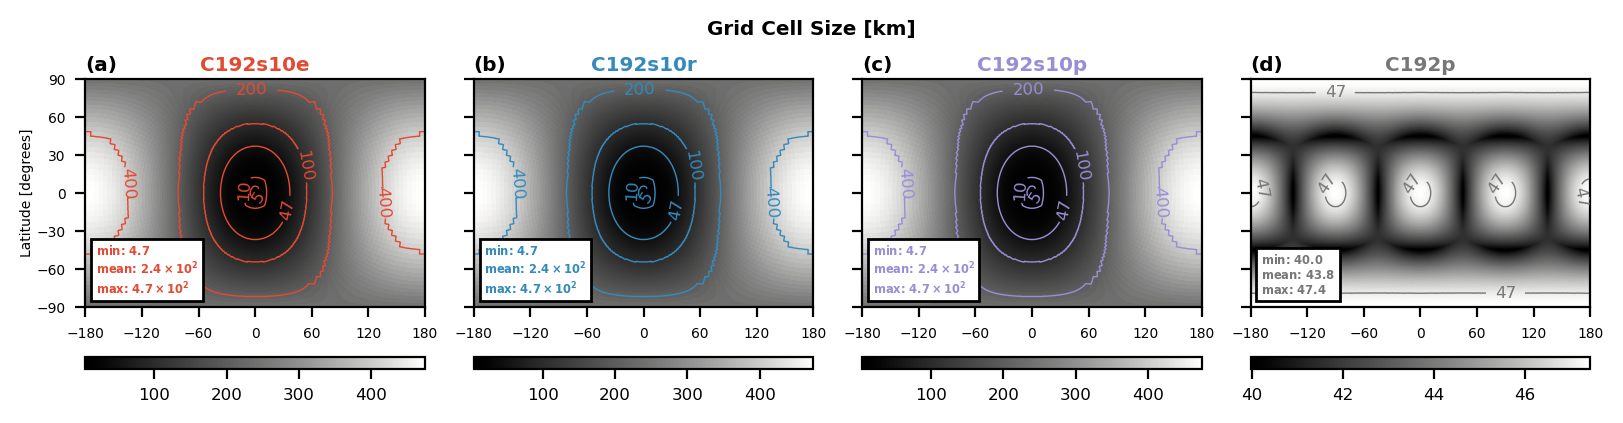

In [47]:
savefig = True
fmt = "pretty"
levels = [5, 10, 47, 100, 200, 400]

fig = plt.figure(figsize=(8, 2), layout="constrained")
mosaic = [show_sim, [f"{i}-cax" for i in show_sim]]
fig.suptitle(f"Grid Cell Size [km]", fontweight="bold")
axd = fig.subplot_mosaic(mosaic, height_ratios=[1, 0.05])

iletters = subplot_label_generator()
for sim_label in show_sim:
    ax = axd[sim_label]
    ax.set_title(
        f"({next(iletters)})",
        loc="left",
        fontdict={"weight": "bold"},
        pad=3,
    )
    ax.set_title(
        SIMULATIONS[sim_label].title,
        loc="center",
        fontdict={"weight": "bold"},
        pad=3,
        color=SIMULATIONS[sim_label].kw_plt["color"],
    )
    cube = dset[sim_label].extract_cube("cell_area") ** 0.5
    cube.convert_units("km")
    y, x = cube.dim_coords
    if coord_mapping := coord_mappings.get(x.name()):
        x.convert_units(coord_mapping["units"])
        ax.set_xticks(coord_mapping["ticks"])
        ax.set_xlim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
    if coord_mapping := coord_mappings.get(y.name()):
        y.convert_units(coord_mapping["units"])
        ax.set_yticks(coord_mapping["ticks"])
        ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(f"{capitalise(y.name())} [{y.units}]", size="small", labelpad=1)
    else:
        ax.set_yticklabels([])
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel(f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1)
    ax.tick_params(labelsize="small")
    h0 = ax.pcolormesh(x.points, y.points, cube.data, cmap=cmocean.cm.gray)
    cbar = fig.colorbar(h0, cax=axd[f"{sim_label}-cax"], orientation="horizontal")
    h1 = ax.contour(
        x.points,
        y.points,
        cube.data,
        levels=levels,
        colors=SIMULATIONS[sim_label].kw_plt["color"],
        linewidths=0.5,
    )
    ax.clabel(h1, fmt="%.0f")
    if iris.util.guess_coord_axis(x) == "X" and iris.util.guess_coord_axis(y) == "Y":
        at = ax.add_artist(
            AnchoredText(
                cube_minmeanmax_str(
                    cube,
                    fmt=fmt,
                    precision=1,
                    sep="\n",
                    eq_sign=": ",
                ),
                loc="lower left",
                frameon=True,
                prop={
                    "size": "x-small",
                    "weight": "bold",
                    "color": SIMULATIONS[sim_label].kw_plt["color"],
                },
            )
        )
        # at.set_path_effects([path_effects.Stroke(linewidth=1, foreground="w")])

if savefig:
    figsave(
        fig,
        paths.figures / "drafts" / f"regr__{'_'.join(show_sim)}__cell_width",
    )

## Longitudinal profiles

Like Fig. S10 in Yang et al. (2023)

In [21]:
def lfric_precip_sum(dset, const=const):
    """Calculate total precipitation by adding its convective and large-scale components."""
    ls_p = dset.extract_cube("ls_prec")
    ls_p = ls_p.copy(data=ls_p.data.filled(fill_value=0))
    cv_p = dset.extract_cube("conv_prec")
    cv_p = cv_p.copy(data=cv_p.data.filled(fill_value=0))
    p_sum = (ls_p + cv_p) / const.condensible_density
    return p_sum

In [22]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str


DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.t_sfc),
        title="Surface Temperature",
        units="$K$",
    ),
    "toa_olr": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.toa_olr),
        title="TOA Outgoing Longwave Radiation",
        units="$W$ $m^{-2}$",
    ),
    "caf": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.caf),
        title="Cloud Fraction",
        units="%",
    ),
    "caf_vl": Diag(
        recipe=lambda cl: cl.extract_cube("very_low_type_cloud_amount"),
        title="Very Low Cloud Fraction",
        units="%",
    ),
    "caf_l": Diag(
        recipe=lambda cl: cl.extract_cube("low_type_cloud_amount"),
        title="Low Cloud Fraction",
        units="%",
    ),
    "caf_m": Diag(
        recipe=lambda cl: cl.extract_cube("medium_type_cloud_amount"),
        title="Medium Cloud Fraction",
        units="%",
    ),
    "caf_h": Diag(
        recipe=lambda cl: cl.extract_cube("high_type_cloud_amount"),
        title="High Cloud Fraction",
        units="%",
    ),
    "caf_vh": Diag(
        recipe=lambda cl: cl.extract_cube("very_high_type_cloud_amount"),
        title="Very High Cloud Fraction",
        units="%",
    ),
    "tot_col_m_v": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_v"),
        title="Total Column Water Vapour",
        units="$kg$ $m^{-2}$",
    ),
    "tot_col_m_cl": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_cl"),
        title="Total Column Cloud Liquid",
        units="$kg$ $m^{-2}$",
    ),
    "tot_col_m_ci": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_ci"),
        title="Total Column Cloud Ice",
        units="$kg$ $m^{-2}$",
    ),
    "ls_prec": Diag(
        recipe=lambda cl: cl.extract_cube("ls_prec") / const.condensible_density,
        title="Large-scale Precipitation Rate",
        units="$mm$ $day^{-1}$",
    ),
    "conv_prec": Diag(
        recipe=lambda cl: cl.extract_cube("conv_prec") / const.condensible_density,
        title="Convective Precipitation Rate",
        units="$mm$ $day^{-1}$",
    ),
    "tot_prec": Diag(
        recipe=lfric_precip_sum,
        title="Total Precipitation Rate",
        units="$mm$ $day^{-1}$",
    ),
    "tot_col_uv_kinetic_energy": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_uv_kinetic_energy"),
        title="Total Column Horizontal Kinetic Energy",
        units="$10^6$ $J$ $m^{-2}$",
    ),
    "tot_col_w_kinetic_energy": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_w_kinetic_energy"),
        title="Total Column Vertical Kinetic Energy",
        units="$J$ $m^{-2}$",
    ),
}

Saved to ../figures/drafts/regr__c192s10e_c192s10r_c192s10p_c192p__caf_caf_vl_caf_l_caf_m_caf_h_caf_vh__tmm.png
Size: 148.7 KB


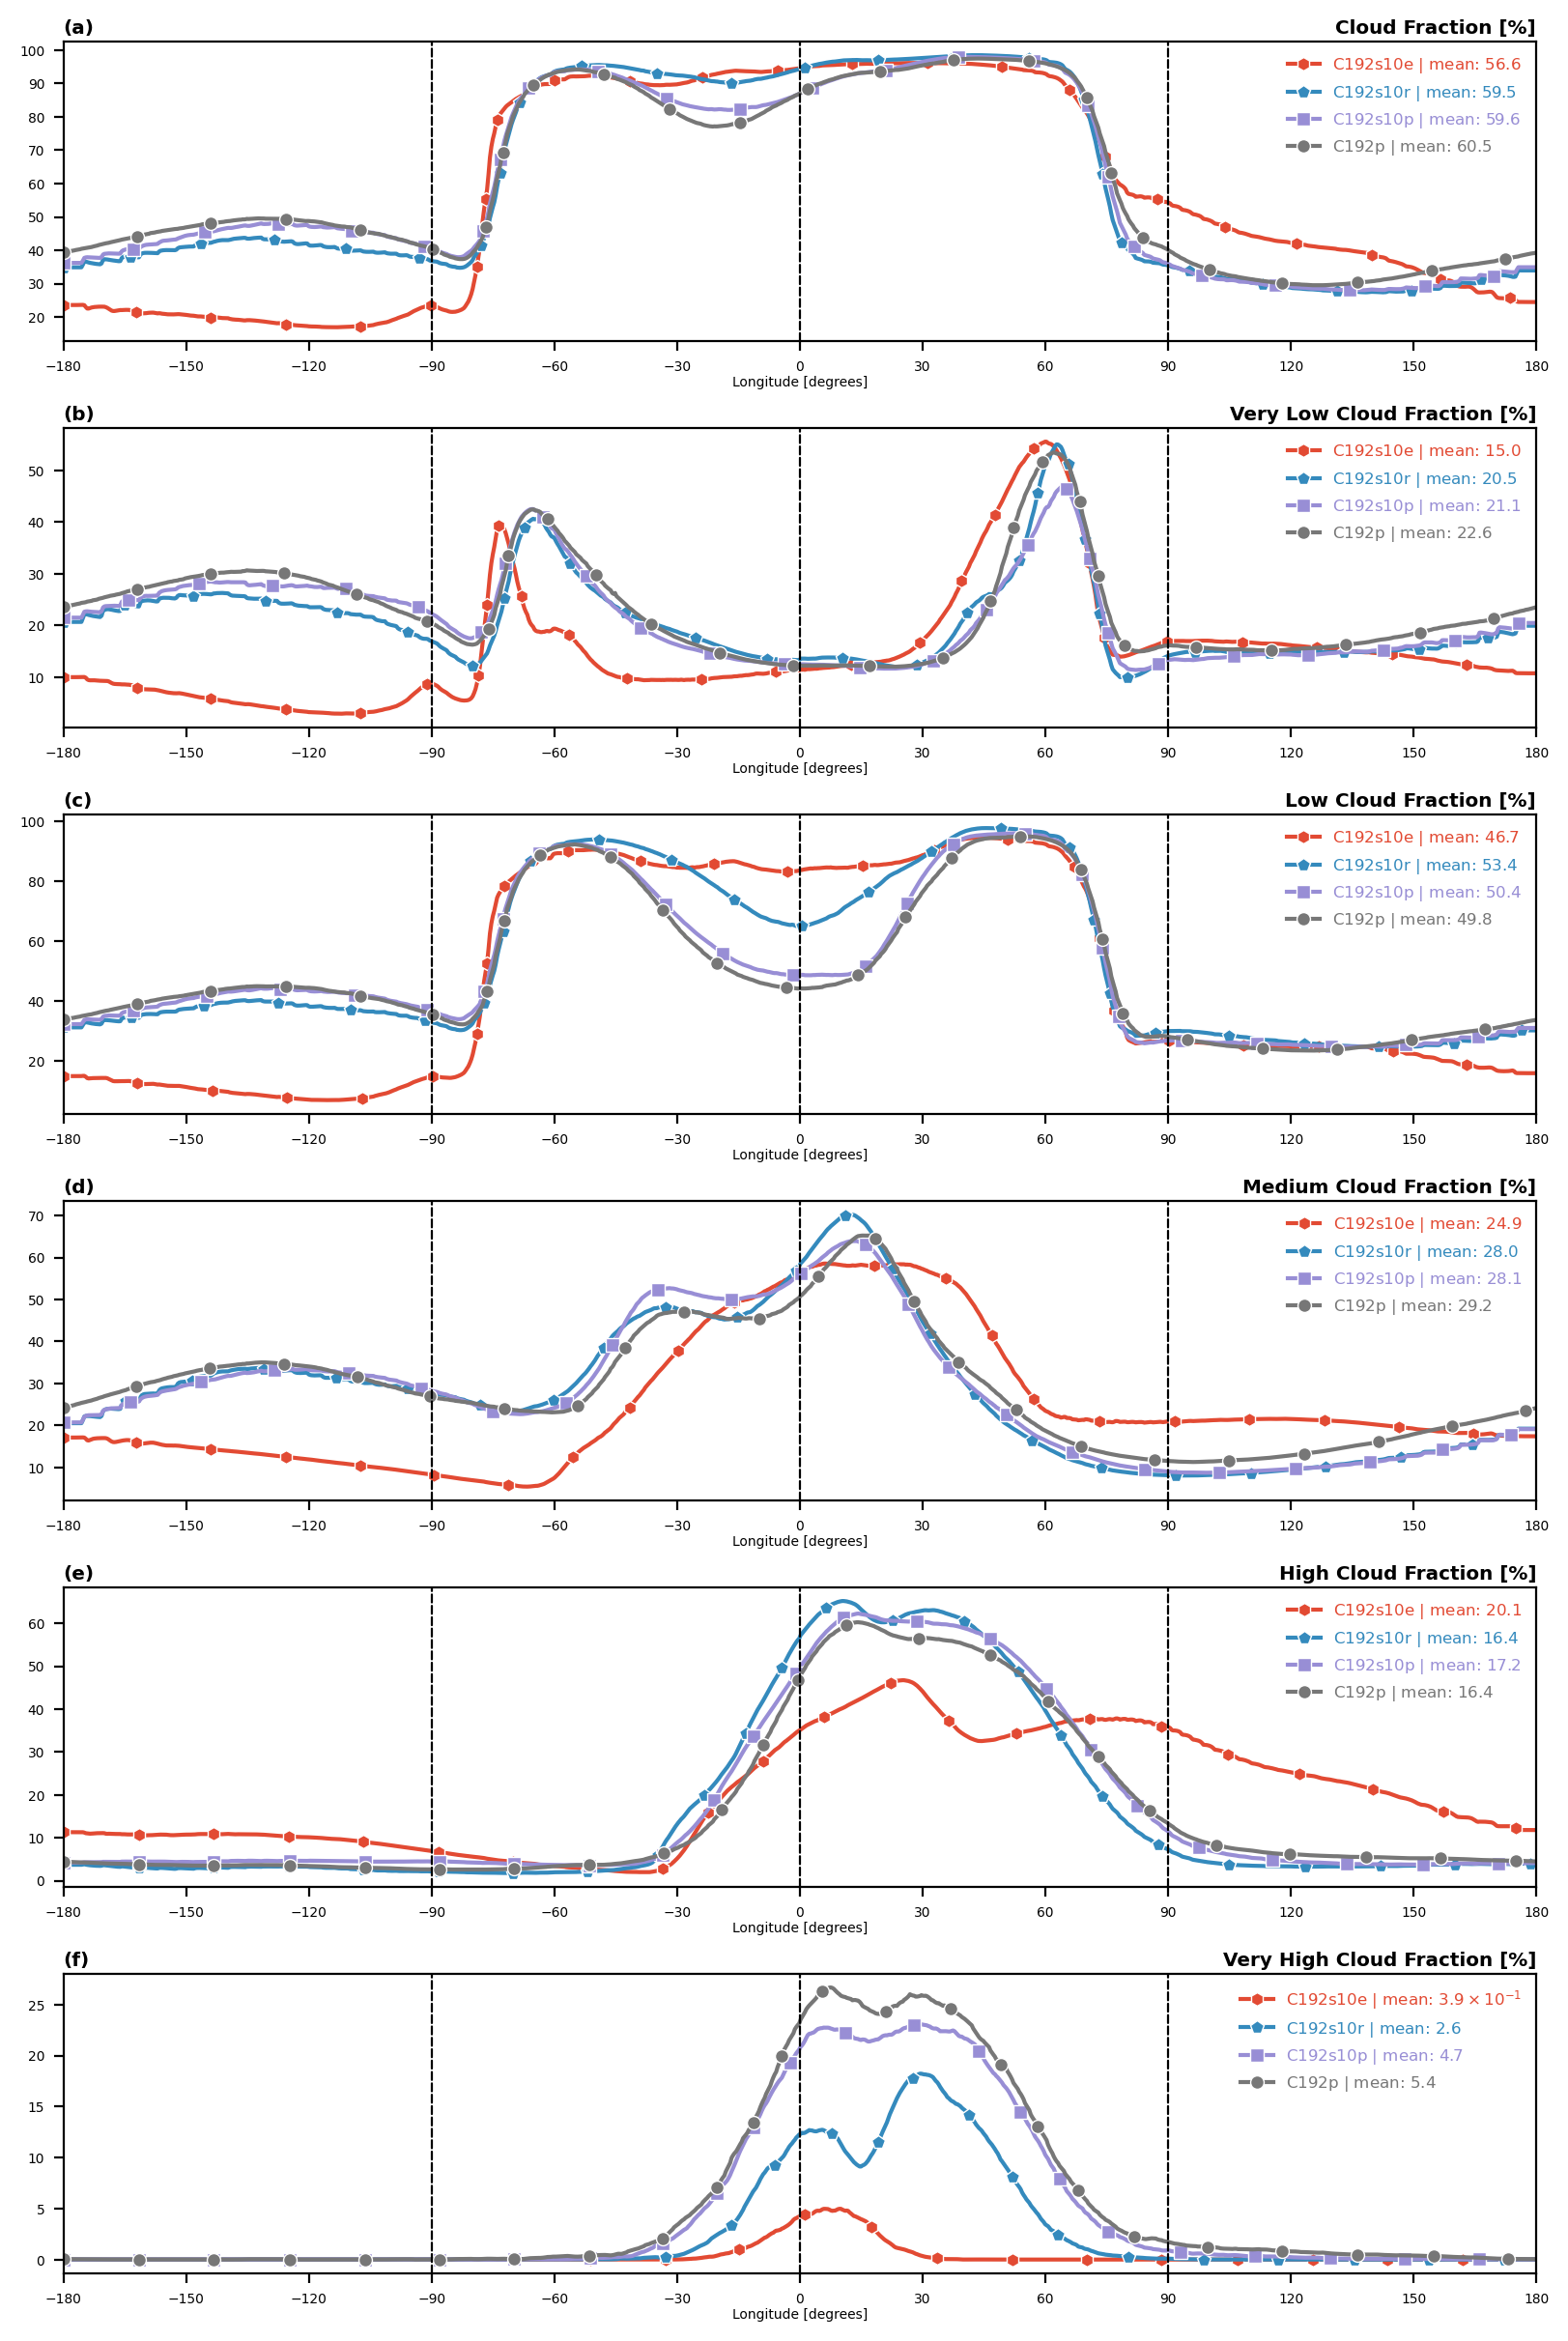

In [27]:
# diag_keys = ["tot_col_uv_kinetic_energy", "tot_col_w_kinetic_energy"]
# diag_keys = ["tot_col_m_v", "tot_col_m_cl", "tot_col_m_ci"]
# diag_keys = ["tot_prec", "ls_prec", "conv_prec"]
# diag_keys = ["t_sfc", "toa_olr", "caf"]
diag_keys = ["caf", "caf_vl", "caf_l", "caf_m", "caf_h", "caf_vh"]
savefig = True
fmt = "pretty"
reduce_func = lambda cube: meridional_mean(cube, model=lfric)


fig = plt.figure(figsize=(8, 2 * len(diag_keys)), layout="constrained")
mosaic = [[i] for i in diag_keys]
axd = fig.subplot_mosaic(mosaic)

iletters = subplot_label_generator()
for diag_key in diag_keys:
    ax = axd[diag_key]
    for sim_label in show_sim:
        cube = reduce_func(DIAGS[diag_key].recipe(dset[sim_label]))
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        if iris.util.is_masked(cube.data):
            continue
        else:
            mmm_str = cube_minmeanmax_str(
                cube,
                fmt=fmt,
                precision=1,
                sep=" | ",
                eq_sign=": ",
            ).split(" | ")[1]
            # print(diag_key, sim_label, e)
            (x,) = cube.dim_coords
            h = ax.plot(
                x.points,
                cube.data,
                markevery=0.05,
                markersize=5,
                markeredgecolor="w",
                markeredgewidth=0.5,
                **SIMULATIONS[sim_label].kw_plt,
                label=f"{SIMULATIONS[sim_label].title} | {mmm_str}",
            )
    ax.legend(
        frameon=False,
        # loc="upper left",
    )
    ax.set_title(
        f"({next(iletters)})",
        loc="left",
        fontdict={"weight": "bold"},
        pad=3,
    )
    ax.set_title(
        f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]",
        loc="right",
        fontdict={"weight": "bold"},
        pad=3,
    )
    ax.set_xticks(np.arange(-180, 181, 30))
    ax.set_xlim(-180, 180)
    ax.tick_params(labelsize="small")
    ax.set_xlabel(f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1)
    for xval in [-90, 0, 90]:
        ax.axvline(x=xval, **KW_ZERO_LINE)

if savefig:
    figsave(
        fig,
        paths.figures
        / "drafts"
        / f"regr__{'_'.join(show_sim)}__{'_'.join(diag_keys)}__tmm",
    )

## Vertical Profiles

In [7]:
@dataclass
class SpatialOp:
    recipe: callable
    title: str


SPATIAL_OP = {
    "ss": SpatialOp(
        recipe=lambda cube: cube.interpolate(
            [(lfric.x, 0), (lfric.y, 0)], iris.analysis.Linear()
        ),
        title="Substellar Point",
    ),
    "as": SpatialOp(
        recipe=lambda cube: cube.interpolate(
            [(lfric.x, 180), (lfric.y, 0)], iris.analysis.Linear()
        ),
        title="Antistellar Point",
    ),
    "west_term": SpatialOp(
        recipe=lambda cube: meridional_mean(
            cube.extract(
                iris.Constraint(**{lfric.x: -90}),
            )
        ),
        title="Western (morning) terminator",
    ),
    "east_term": SpatialOp(
        recipe=lambda cube: meridional_mean(
            cube.extract(
                iris.Constraint(**{lfric.x: 90}),
            )
        ),
        title="Eastern (evening) terminator",
    ),
}

In [19]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    kw_axline: dict = None
    xscale: str = "linear"
    xlim: list = None
    inset_bounds: list = None
    inset_xlim: list = None
    inset_ylim: Optional = (0, 10)
    inset_yticks: Optional = (0, 2, 4, 6, 8, 10)


DIAGS = {
    "temp": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.temp),
        title="Temperature",
        units="$K$",
        # ss
        # xlim=[170, 300],
        # inset_xlim=[220, 295],
        # inset_bounds=[0.55, 0.55, 0.4, 0.4],
        # west_term
        # xlim=[170, 265],
        # inset_xlim=[190, 260],
        # inset_bounds=[0.55, 0.55, 0.4, 0.4],
        # east_term
        xlim=[170, 280],
        inset_xlim=[210, 270],
        inset_bounds=[0.55, 0.55, 0.4, 0.4],
    ),
    "theta": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.thta),
        title="Potential Temperature",
        units="$K$",
        xlim=[270, 500],
        inset_xlim=[280, 330],
        inset_bounds=[0.1, 0.55, 0.4, 0.4],
    ),
    "lapse_rate": Diag(
        recipe=lambda cl: d_dz(cl.extract_cube(lfric.temp), model=lfric),
        title="Lapse Rate",
        units="$K$ $km^{-1}$",
        kw_axline=dict(xy1=(0, 0), xy2=(0, 1)),
        xlim=[-11, 3],
        inset_xlim=[-10, -4],
        inset_bounds=[0.35, 0.55, 0.4, 0.4],
    ),
    "dtheta_dz": Diag(
        recipe=lambda cl: d_dz(cl.extract_cube(lfric.thta), model=lfric),
        title=r"$d\theta/dz$",
        units="$K$ $km^{-1}$",
        kw_axline=dict(xy1=(0, 0), xy2=(0, 1)),
        xlim=[-1.5, 20],
        inset_xlim=[-1, 7],
        inset_bounds=[0.55, 0.55, 0.4, 0.4],
        inset_ylim=(0, 19),
        inset_yticks=(0, 2, 4, 6, 8, 10, 12, 14, 16, 18),
    ),
    "w": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.w),
        title="Upward Velocity",
        units="$cm$ $s^{-1}$",
        kw_axline=dict(xy1=(0, 0), xy2=(0, 1)),
        xlim=[-1, 10],
        inset_xlim=[-0.5, 9.5],
        inset_bounds=[0.35, 0.55, 0.4, 0.4],
        inset_ylim=(0, 19),
        inset_yticks=(0, 2, 4, 6, 8, 10, 12, 14, 16, 18),
    ),
    "m_v": Diag(
        recipe=lambda cl: cl.extract_cube("m_v"),
        title="Water Vapour Mixing Ratio",
        units="$kg$ $kg^{-1}$",
        xscale="log",
        # ss
        # xlim=[1e-7, 3e-2],
        # inset_xlim=[1e-4, 2e-2],
        # inset_bounds=[0.35, 0.55, 0.4, 0.4],
        # west_term
        # xlim=[1e-7, 5e-4],
        # inset_xlim=[1e-6, 4e-4],
        # inset_bounds=[0.55, 0.55, 0.4, 0.4],
        # east_term
        xlim=[1e-7, 4e-3],
        inset_xlim=[5e-6, 2e-3],
        inset_bounds=[0.55, 0.55, 0.4, 0.4],
    ),
    "m_cl": Diag(
        recipe=lambda cl: cl.extract_cube("m_cl"),
        title="Cloud Liquid Mixing Ratio",
        units="$kg$ $kg^{-1}$",
        xscale="log",
        # ss
        # xlim=[1e-7, 2e-4],
        # inset_xlim=[5e-7, 1e-4],
        # inset_bounds=[0.35, 0.55, 0.4, 0.4],
        # west_term
        xlim=[1e-11, 1e-5],
        inset_xlim=[1e-10, 5e-6],
        inset_bounds=[0.35, 0.55, 0.4, 0.4],
    ),
    "m_ci": Diag(
        recipe=lambda cl: cl.extract_cube("m_ci"),
        title="Cloud Ice Mixing Ratio",
        units="$kg$ $kg^{-1}$",
        xscale="log",
        # ss
        # xlim=[1e-11, 4e-4],
        # inset_xlim=[1e-5, 3e-4],
        # inset_bounds=[0.55, 0.55, 0.4, 0.4],
        # west_term
        # xlim=[1e-12, 2e-5],
        # inset_xlim=[1e-7, 1e-5],
        # inset_bounds=[0.55, 0.55, 0.4, 0.4],
        # east_term
        xlim=[1e-12, 2e-5],
        inset_xlim=[1e-7, 1e-5],
        inset_bounds=[0.55, 0.55, 0.4, 0.4],
    ),
}

Saved to ../figures/drafts/regr__c192s10e_c192s10r_c192s10p_c192p__temp_m_v_m_cl_m_ci__tm_east_term.png
Size: 79.3 KB


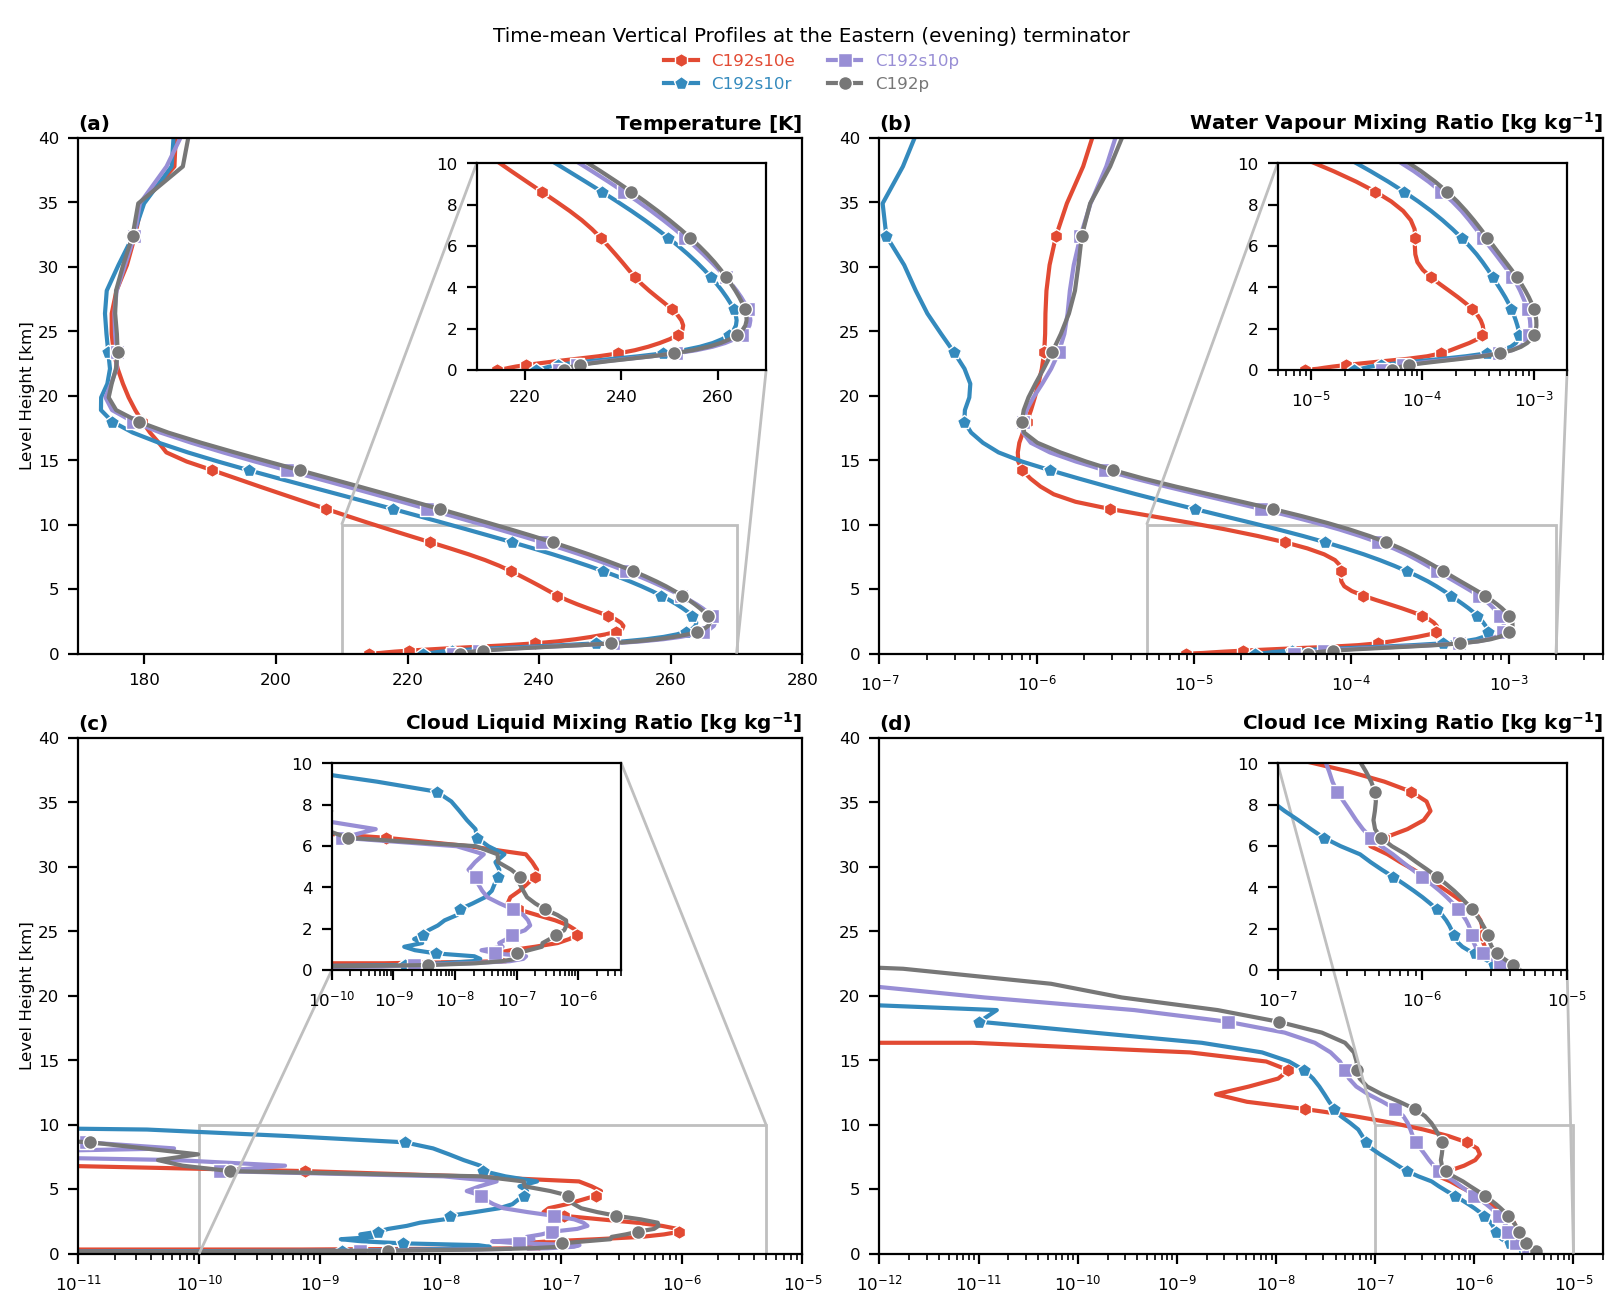

In [20]:
savefig = True
diag_keys = ["temp", "m_v", "m_cl", "m_ci"]
# diag_keys = ["temp", "theta", "lapse_rate", "dtheta_dz"]
# diag_keys = ["temp", "theta", "lapse_rate", "w"]
so_key = "east_term"
kw_common = dict(
    markevery=5,
    markersize=5,
    markeredgecolor="w",
    markeredgewidth=0.5,
)
fig = plt.figure(figsize=(8, 3 * (len(diag_keys) // 2)), layout="constrained")
axd = fig.subplot_mosaic(
    [diag_keys[i : i + 2] for i in range(0, len(diag_keys), 2)],
    # gridspec_kw={"wspace": 0.1, "hspace": 0.4},
)
iletters = subplot_label_generator()

for diag_key in diag_keys:
    ax = axd[diag_key]
    axins = ax.inset_axes(DIAGS[diag_key].inset_bounds)
    for isim, sim_label in enumerate(show_sim):
        cube = SPATIAL_OP[so_key].recipe(DIAGS[diag_key].recipe(dset[sim_label]))
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        if iris.util.is_masked(cube.data):
            continue
        (y,) = cube.dim_coords
        if coord_mapping := coord_mappings.get(y.name()):
            y.convert_units(coord_mapping["units"])
            ax.set_yticks(coord_mapping["ticks"])
            ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        for _ax in [ax, axins]:
            _ax.plot(
                cube.data,
                y.points,
                **kw_common,
                **SIMULATIONS[sim_label].kw_plt,
            )

    ax.set_title(
        f"({next(iletters)})",
        loc="left",
        fontdict={"weight": "bold"},
        pad=3,
    )
    ax.set_title(
        f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]",
        loc="right",
        fontdict={"weight": "bold"},
        pad=3,
    )
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(f"{capitalise(y.name())} [{y.units}]", size="medium", labelpad=1)
    if not ax.get_subplotspec().is_first_col():
        ax.set(ylabel="")
    ax.set(
        xscale=getattr(DIAGS[diag_key], "xscale", "linear"),
        xlim=getattr(DIAGS[diag_key], "xlim", None),
    )
    axins.set(
        xscale=getattr(DIAGS[diag_key], "xscale", "linear"),
        xlim=getattr(DIAGS[diag_key], "inset_xlim", None),
        yscale="linear",
        ylim=DIAGS[diag_key].inset_ylim,
        yticks=DIAGS[diag_key].inset_yticks,
    )
    mark_inset(
        ax,
        axins,
        loc1=1 if DIAGS[diag_key].inset_bounds[0] < 0.5 else 2,
        loc2=3 if DIAGS[diag_key].inset_bounds[0] < 0.5 else 4,
        edgecolor="0.75",
    )
    if kw_axline := DIAGS[diag_key].kw_axline:
        ax.axline(**kw_axline, **KW_ZERO_LINE)
        axins.axline(**kw_axline, **KW_ZERO_LINE)

add_custom_legend(
    fig,
    {
        SIMULATIONS[sim_label].title: {**kw_common, **SIMULATIONS[sim_label].kw_plt}
        for sim_label in show_sim
    },
    loc="upper center",
    frameon=False,
    ncol=2,
    fontsize="medium",
    title_fontsize="large",
    title=f"Time-mean Vertical Profiles at the {SPATIAL_OP[so_key].title}",
    bbox_to_anchor=(0.5, 1.075),
)

if savefig:
    figsave(
        fig,
        paths.figures
        / "drafts"
        / f"regr__{'_'.join(show_sim)}__{'_'.join(diag_keys)}__tm_{so_key}",
    )

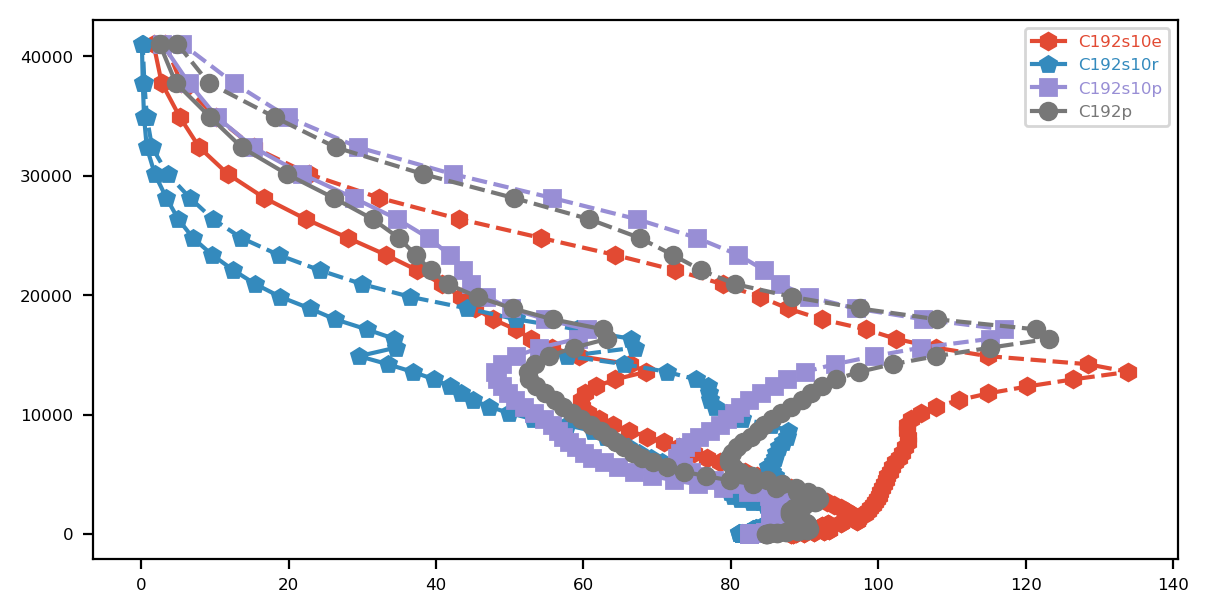

In [33]:
ax = plt.axes()

for sim_label in show_sim:
    cube3d = dset[sim_label].extract_cube("rh_water")
    cube1d = cube3d.interpolate([(lfric.x, 0), (lfric.y, 0)], iris.analysis.Linear())
    ax.plot(
        cube1d.data,
        heights,
        **SIMULATIONS[sim_label].kw_plt,
        label=SIMULATIONS[sim_label].title,
    )
    cube3d = dset[sim_label].extract_cube("rh_ice")
    cube1d = cube3d.interpolate([(lfric.x, 0), (lfric.y, 0)], iris.analysis.Linear())
    ax.plot(
        cube1d.data,
        heights,
        **SIMULATIONS[sim_label].kw_plt,
        linestyle="--",
    )
# ax.set_yscale("log")
ax.legend();

## Tidally-locked coordinates

In [5]:
dset_tl = {}
for sim_label in show_sim:
    dset_tl[sim_label] = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label]["long_name"]
        / f"{SIMULATIONS[sim_label]['long_name']}_{time_prof}_*_tl_coord__time_and_zonal_mean.nc".lower()
    )

In [8]:
for i, cube in enumerate(dset_tl[sim_label]):
    print(f"---|---|-{'-'*30}-|-{'-'*60}")
    print(f"{i:<2d} | {cube.ndim} | {cube.var_name:>30} | {cube.name():>60}")

---|---|--------------------------------|-------------------------------------------------------------
0  | 1 |                   tot_col_m_ci |                         atmosphere_mass_content_of_cloud_ice
---|---|--------------------------------|-------------------------------------------------------------
1  | 1 |       tot_col_w_kinetic_energy |                   atmosphere_vertical_kinetic_energy_content
---|---|--------------------------------|-------------------------------------------------------------
2  | 2 |                            m_v |                                          vapour_mixing_ratio
---|---|--------------------------------|-------------------------------------------------------------
3  | 2 |                   exner_in_wth |                            exner_pressure_at_cell_interfaces
---|---|--------------------------------|-------------------------------------------------------------
4  | 1 |                    tot_col_m_v |                       atmospher

In [9]:
lats = (
    dset_tl[sim_label].extract(DimConstr(model=lfric).relax.y)[0].coord(lfric.y).points
)
heights = (
    dset_tl[sim_label].extract(DimConstr(model=lfric).relax.z)[0].coord(lfric.z).points
)

In [10]:
Diag = NamedTuple(
    "Diag", [("recipe", callable), ("title", str), ("kw_plt", dict), ("units", str)]
)

In [37]:
DIAGS = {
    "w": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.w),
        title="Upward Wind",
        units="$m$ $s^{-1}$",
        kw_plt=dict(
            cmap=cmocean.cm.balance,
            levels=linspace_pm1(8) * 0.05,
            extend="both",
        ),
    ),
    "temp": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.thta) * cl.extract_cube(lfric.exner),
        title="Temperature",
        units="$K$",
        kw_plt=dict(
            cmap=cmocean.cm.thermal,
            levels=np.arange(170, 271, 10),
            extend="both",
        ),
    ),
    "m_v": Diag(
        recipe=lambda cl: cl.extract_cube("m_v"),
        title="Water Vapour",
        units="$g$ $kg^{-1}$",
        kw_plt=dict(
            cmap=cmocean.cm.ice,
            # levels=np.arange(0.4, 2.9, 0.4),
            norm=mcol.LogNorm(1e-8, 1e2),
            extend="both",
        ),
    ),
    "m_cl": Diag(
        recipe=lambda cl: cl.extract_cube("m_cl"),
        title="Cloud Liquid Water",
        units="$g$ $kg^{-1}$",
        kw_plt=dict(
            cmap=cmocean.cm.ice,
            # levels=np.arange(0.4, 2.9, 0.4),
            norm=mcol.LogNorm(),
            extend="both",
        ),
    ),
    "m_ci": Diag(
        recipe=lambda cl: cl.extract_cube("m_ci"),
        title="Cloud Ice",
        units="$g$ $kg^{-1}$",
        kw_plt=dict(
            cmap=cmocean.cm.ice,
            # levels=np.arange(0.4, 2.9, 0.4),
            norm=mcol.LogNorm(),
            extend="both",
        ),
    ),
    "rh_water": Diag(
        recipe=lambda cl: cl.extract_cube("rh_ice"),
        title="Relative humidity (w.r.t. water)",
        units="1",
        kw_plt=dict(
            # cmap=cmocean.cm.haline_r,
            # levels=np.arange(0, 101, 10),
            # extend="both",
        ),
    ),
}

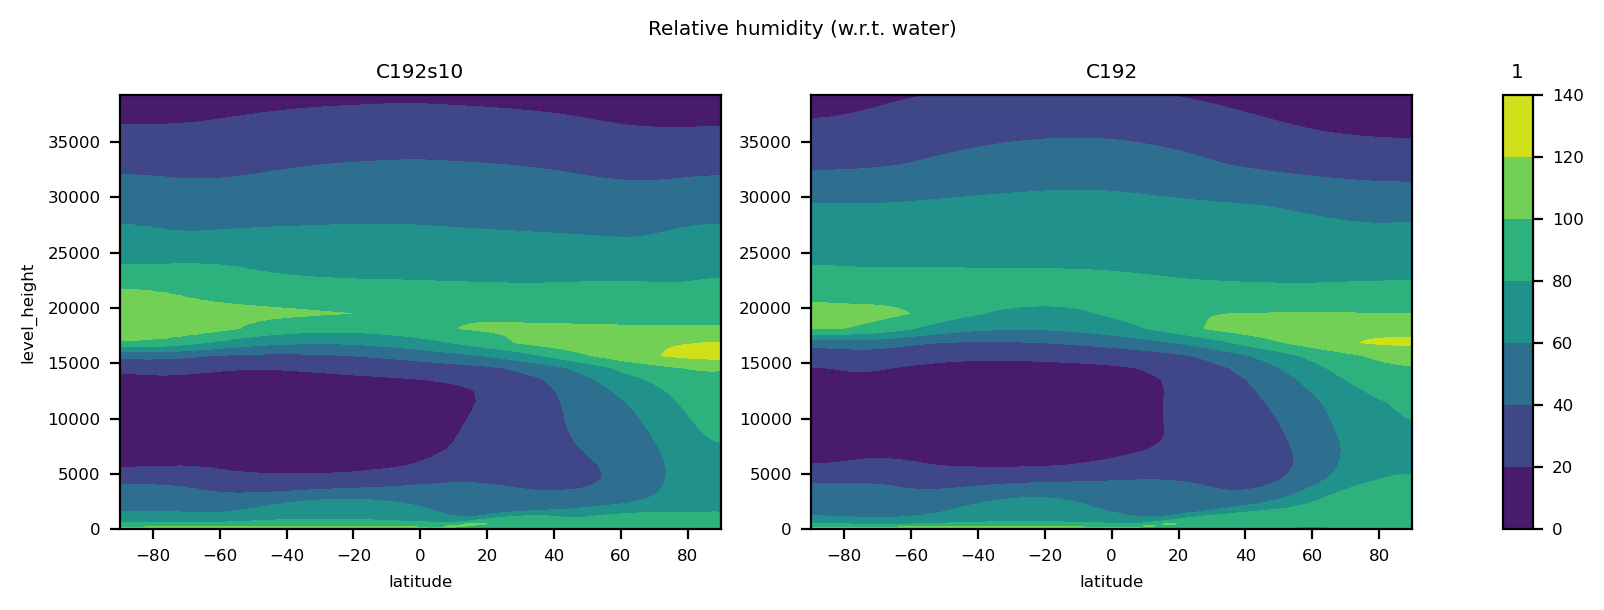

In [38]:
for diag_key in ["rh_water"]:  #
    mosaic = [show_sim + ["cax"]]

    fig = plt.figure(figsize=(8, 3))
    fig.suptitle(DIAGS[diag_key].title)
    axd = fig.subplot_mosaic(mosaic, width_ratios=[20, 20, 1])
    for sim_label in show_sim:
        axd[sim_label].set_title(SIMULATIONS[sim_label]["title"])
        cube = DIAGS[diag_key].recipe(dset_tl[sim_label])
        if cube.units == "ms-1":
            cube.units = "m s-1"
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        y, x = cube.dim_coords
        h = axd[sim_label].contourf(
            x.points, y.points, cube.data, **DIAGS[diag_key].kw_plt
        )
        if axd[sim_label].get_subplotspec().is_first_col():
            axd[sim_label].set_ylabel(y.name())
        if axd[sim_label].get_subplotspec().is_last_row():
            axd[sim_label].set_xlabel(x.name())
    cbar = fig.colorbar(h, cax=axd["cax"])
    cbar.ax.set_title(DIAGS[diag_key].units)
    fig.tight_layout()